# Zonal Statistics from Composite Raster for enhanced AOI GPKG and Population Pyramid Creation Notebook

### This notebook is designed to be run using the outputs (composite.tif) from the "world_pop_processing" notebook.

## **Note:** This notebook is designed to be run in ArcGIS Pro due to dependencies on Arc packages. Running it outside ArcGIS Pro will result in errors.

### To open a notebook in ArcGIS Pro, click 'Add and Open Notebook' as shown below:
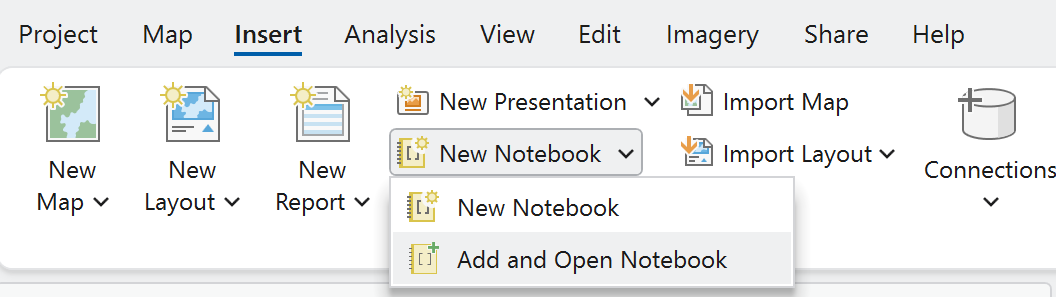

### ! Ensure that the root pathway in the script is personalised before running the notebook!

###### Version: rev3 Author: Maria Fedyszyn, Last updated: 26/08/2025.


**Structure of the notebook is as follows:**
1) Imports
2) Configure paths and parameters
3) ArcGIS environment, setup and checks
4) Helpers
5) Plotting helpers
6) Main streamlined pipeline
7) Run


**Expected output structure of the notebook is as follows:**
```
outputs/
├── csvs/
│   ├── population_master.csv      # All polygons in one table (location + stats)
│   └── <location>.csv             # One CSV per polygon, tidy with ages + grouped rows
├── pyramids/
│   ├── <location>_summary.png     # Grouped population pyramid
│   └── <location>_detailed.png    # Per-age population pyramid
├── gpkg/
│   ├── all.gpkg                   # Overall layer (AOI_enhanced) with all polygons
│   └── <location>.gpkg            # One GeoPackage per polygon, trimmed attributes
└── scratch.gdb/                   # Temporary workspace (can be deleted after run)
```

All output vectors are saved as GeoPackage files, allowing you to open them in ArcGIS Pro, QGIS, and other GIS tools.

#### You can customise

* `root` – your project directory.
* `composite` – path to the multiband raster (if stored elsewhere or differently named).
* `aoi_folder` – folder containing your AOIs (`.shp`, `.geojson`, `.json`).
* Output layout – `outputs_root`, `csv_dir`, `pyr_dir`, `gpkg_dir`, `scratch_gdb`.
* Overall vector – `overall_gpkg` and `overall_layer` (file and layer name).
* Age groups – `AGE_GROUPS` to define buckets, e.g. `{"ranges": [(0,14)]}` or explicit `{"codes": [0,1,"02"]}`; the notebook will auto-match to available ages.
* Label fields – `LABEL_FIELDS` is an ordered list of AOI attribute names to try (first non-empty wins) and will be written to the `location` field and used in filenames.
* Whether plot titles are included – toggle in the plotting cell via `SHOW_TITLE = True/False`.
* Whether output values are made into integers – run the optional “integer outputs” cell to round all numeric fields before export.


## 1) Imports
This cell loads everything the notebook uses: ArcGIS `arcpy` for geoprocessing, `pandas` and `numpy` for tabular work, `matplotlib` for charts, and a few standard libraries for paths, text handling and progress bars.

You usually do not need to touch this. If your environment is missing a package, you can add the import here.

### How to handle missing packages

If you see an error like ModuleNotFoundError: No module named 'tqdm':

Add the import line in the Imports cell, for example:

`from tqdm.auto import tqdm`


**If** the import still fails, install the package into ArcGIS Pro’s Python environment:

- In ArcGIS Pro: Project → Python → Package Manager → search for the package → Install.
- Or use the Python Command Prompt (ArcGIS Pro):

`conda activate arcgispro-py3`

`conda install -c conda-forge tqdm`

Reopen the notebook or restart the kernel, then run the Imports cell again.

In [ ]:
import os, re, warnings
from pathlib import Path
from functools import reduce
import unicodedata

import arcpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kw): return x

# Regex helpers, used for identifying the patterns in band names
BAND_NAME_RE = re.compile(r"([fmt])_age_(\d{2})$", re.I)  # raw bands like m_age_00, f_age_37, t_age_12
RAW_AGE_RE   = re.compile(r"^[mft]_age_(\d{2})$")        # matches any raw age field

## 2) Configure paths and parameters

This cell sets all inputs and outputs in one place so the rest of the notebook stays simple. Point `root` at your project folder; set the composite multiband raster and the AOI folder. The input folders should already exist from the first WorldPop analysis notebook. Output folders will be created if they do not already exist. All GeoPackages go into a single `gpkg` folder; the overall file is `all.gpkg` with layer name `AOI_enhanced`. Per-polygon CSVs and pyramids are named by the resolved **location**.

In [ ]:
root = Path(r"C:\Users\ETC")

# Inputs
composite  = str(root / "composite_raster" / "composite.tif")   # multiband raster
aoi_folder = str(root / "AOI")             # folder with .shp / .geojson / .json

# Outputs (all GeoPackages go here)
outputs_root = root / "outputs"
gpkg_dir     = outputs_root / "gpkg" 
csv_dir      = outputs_root / "csvs"
pyr_dir      = outputs_root / "pyramids"
scratch_gdb  = outputs_root / "scratch.gdb"

# Overall (all AOIs) GeoPackage and layer
overall_gpkg  = gpkg_dir / "all.gpkg"
overall_layer = "AOI_enhanced"

# Age groups (edit freely)
AGE_GROUPS = {
    "0_14":    {"ranges": [(0, 14)]},
    "15_44":   {"ranges": [(15, 44)]},
    "45_plus": {"ranges": [(45, 99)]}
}

# Label fields: first non-empty wins (case-insensitive)
LABEL_FIELDS = ["LOCATION", "PLACE", "NAME"] #add/remove as required

# Make folders
for p in [outputs_root, gpkg_dir, csv_dir, pyr_dir]:
    p.mkdir(parents=True, exist_ok=True)

print("Composite:", composite)
print("AOI folder:", aoi_folder)
print("GPKG dir:", gpkg_dir)


## 3) ArcGIS environment

This section prepares ArcGIS Pro so the notebook runs consistently. It creates a scratch file geodatabase for temporary data and enables overwrite, so repeated runs do not fail on existing outputs. The Spatial Analyst extension is checked out since zonal statistics require it. The snap raster and cell size are set based on the composite raster, ensuring consistent vector-to-raster alignment. Parallel processing is enabled to speed up heavy operations. Finally, the code validates that the composite raster and AOI folder exist before any real processing begins.

#### You can customise

* **Parallel processing factor** – by default `arcpy.env.parallelProcessingFactor = "100%"` uses all available cores. You can change this line in the environment setup cell, for example `"50%"` would use half the cores.

If you change this setting, re-run the environment setup cell before running the main pipeline.

### 3a) Workspace & overwrite settings

In [ ]:
arcpy.env.overwriteOutput = True
if not arcpy.Exists(str(scratch_gdb)):
    arcpy.management.CreateFileGDB(str(outputs_root), scratch_gdb.name)
print("Scratch GDB:", scratch_gdb)

### 3b) Test Spatial Analyst

In [ ]:
try:
    arcpy.CheckOutExtension("Spatial")
    print("Spatial Analyst: OK")
except Exception as e:
    raise RuntimeError("Spatial Analyst extension is required.") from e

### 3c) Set alignment environment (snap raster, cell size, parallel)

In [ ]:
desc = arcpy.Describe(composite)
arcpy.env.snapRaster = composite
if hasattr(desc, "meanCellWidth") and hasattr(desc, "meanCellHeight"):
    arcpy.env.cellSize = (desc.meanCellWidth, desc.meanCellHeight)
else:
    arcpy.env.cellSize = "MAXOF"
arcpy.env.parallelProcessingFactor = "100%"  # lower to "50%" or "4" if needed

### 3d) Validate inputs

In [ ]:
if not arcpy.Exists(composite):
    raise RuntimeError(f"Composite not found: {composite}")
if not Path(aoi_folder).exists():
    raise RuntimeError(f"AOI folder not found: {aoi_folder}")

print("Env OK. snap:", arcpy.env.snapRaster, "cellSize:", arcpy.env.cellSize)

## 4) Helpers

This section defines a small toolbox of reusable functions used throughout the pipeline. They keep the main workflow clean and make the code easier to maintain.

What the helpers do:

* Collect AOI files from a folder.
* Read band names from the composite raster and keep only those that match patterns like `m_age_XX`, `f_age_XX`, `t_age_XX`.
* Convert multipart AOIs into singlepart polygons and assign each an internal `UID` (used only for processing).
* Move ArcGIS tables to and from pandas cleanly with sensible data types.
* Expand the `AGE_GROUPS` rules into the actual two-digit age codes found in your raster bands.
* Create filename-safe slugs from labels for use in CSV, pyramid, and GeoPackage names.
* Choose human-readable labels for polygons based on the fields you specify in `LABEL_FIELDS`.

#### You can customise

* **Band name regex** – if your raster bands use a different naming convention, adjust the regular expressions in the Imports cell. **This should not be necessary if downloading the WorldPop data from HDX.**

  ```python
  BAND_NAME_RE = re.compile(r"([fmt])_age_(\d{2})$", re.I)
  RAW_AGE_RE   = re.compile(r"^[mft]_age_(\d{2})$")
  ```

  These assume bands like `m_age_00`, `f_age_37`, `t_age_12`.

  * If your bands are named `male_00`, `female_01`, `total_02`, you could use:

    ```python
    BAND_NAME_RE = re.compile(r"(male|female|total)_(\d{2})$", re.I)
    RAW_AGE_RE   = re.compile(r"^(male|female|total)_(\d{2})$", re.I)
    ```
  * If your ages are not zero-padded (e.g. `m_age_0`, `m_age_10`), allow 1–2 digits:

    ```python
    BAND_NAME_RE = re.compile(r"([fmt])_age_(\d{1,2})$", re.I)
    RAW_AGE_RE   = re.compile(r"^[mft]_age_(\d{1,2})$")
    ```

* **Label fields** – in the Configure cell you can edit `LABEL_FIELDS` to match your AOI schema, for example:

  ```python
  LABEL_FIELDS = ["LOCATION", "PLACE", "NAME"]
  ```

  The code tries each field in order and uses the first non-empty value it finds. This value is written to the `location` field and used in filenames.


In [ ]:
def collect_aoi_files(folder):
    files = []
    for ext in ("*.shp", "*.geojson", "*.json"):
        files.extend(Path(folder).glob(ext))
    return [str(p) for p in files]

def get_band_info(raster_path):
    d = arcpy.Describe(raster_path)
    out = []
    for child in getattr(d, "children", []) or []:
        m = BAND_NAME_RE.fullmatch(child.name)
        if m:
            sex = {"m":"male", "f":"female", "t":"total"}[m.group(1).lower()]
            age = m.group(2)
            out.append((child.catalogPath, child.name, sex, age))
    if not out:
        raise ValueError("No bands matched pattern like m_age_00 / f_age_01 / t_age_02.")
    return out

def explode_singlepart(aoi_path, aoi_name, gdb):
    out_fc = arcpy.CreateUniqueName(f"sp_{aoi_name}", str(gdb))
    out_fc = arcpy.management.MultipartToSinglepart(aoi_path, out_fc).getOutput(0)

    def add_if_missing(fc, name, ftype, length=None):
        if not arcpy.ListFields(fc, name):
            arcpy.management.AddField(fc, name, ftype, field_length=length)

    add_if_missing(out_fc, "AOI_NAME", "TEXT", 64)
    add_if_missing(out_fc, "SRC_OID", "LONG")
    add_if_missing(out_fc, "PART_NO", "LONG")
    add_if_missing(out_fc, "UID", "TEXT", 128)

    if not arcpy.ListFields(out_fc, "ORIG_FID"):
        raise RuntimeError("Expected ORIG_FID missing after MultipartToSinglepart.")

    # populate SRC_OID from ORIG_FID
    with arcpy.da.UpdateCursor(out_fc, ["ORIG_FID", "SRC_OID"]) as cur:
        for orig, _ in cur:
            cur.updateRow([orig, orig])

    # assign PART_NO per original feature and build UID
    from collections import defaultdict
    count = defaultdict(int)
    with arcpy.da.UpdateCursor(out_fc, ["AOI_NAME", "ORIG_FID", "PART_NO", "UID"]) as cur:
        for a, orig, pno, uid in cur:
            count[orig] += 1
            cur.updateRow([aoi_name, orig, count[orig], f"{aoi_name}_{orig}_{count[orig]:04d}"])

    try: arcpy.management.AddIndex(out_fc, "UID", "idx_uid")
    except Exception: pass
    return out_fc

def arcpy_table_to_df(table, fields):
    arr = arcpy.da.TableToNumPyArray(table, fields, skip_nulls=False)
    df = pd.DataFrame(arr)
    for f in fields:
        if df[f].dtype == object: df[f] = df[f].astype(str)
    return df

def fc_uid_meta(fc):
    arr = arcpy.da.TableToNumPyArray(fc, ["UID","AOI_NAME","SRC_OID","PART_NO"], skip_nulls=False)
    df = pd.DataFrame(arr)
    df["UID"] = df["UID"].astype(str)
    return df

def slugify(text, maxlen=80):
    s = unicodedata.normalize("NFKD", str(text)).encode("ascii","ignore").decode("ascii")
    s = re.sub(r"[^\w\s-]+","_", s)
    s = re.sub(r"\s+","_", s).strip("_")
    s = re.sub(r"_+","_", s)
    return s[:maxlen].lower()

def choose_first_nonempty(row_dict, candidates_lower, name_map_lower_to_real):
    # candidates_lower: ['location','place',...], keys in row_dict are real case
    for cand in candidates_lower:
        real = name_map_lower_to_real.get(cand)
        if not real: 
            continue
        val = row_dict.get(real)
        if val not in (None, "", " ", "NULL"):
            return real, str(val).strip()
    return None, None

def expand_age_group_codes(group_def, available_codes_set):
    codes = set()
    if "ranges" in group_def:
        for a,b in group_def["ranges"]:
            for age in range(int(a), int(b)+1):
                s = f"{age:02d}"
                if s in available_codes_set:
                    codes.add(s)
    if "codes" in group_def:
        for v in group_def["codes"]:
            s = f"{int(v):02d}" if str(v).isdigit() else str(v)
            if s in available_codes_set:
                codes.add(s)
    return sorted(codes, key=lambda x: int(x))

## 5) Plotting helpers

This section creates the population pyramids with a clean and consistent style. Men are shown in blue on the left and women in pink on the right. The x-axis tick labels are formatted as absolute values, so you never see negative numbers even though men are plotted as negative internally. To keep the images tidy there is no legend, no outer box or grid, and titles are optional via a simple toggle. Age groups are formatted into human-friendly labels: `0_14` becomes `14<`, `15_44` becomes `15-44`, and `45_plus` becomes `45<`. Detailed pyramids use per-age two-digit labels.

#### You can customise

* **Colours** – in the plotting cell, look for the two `barh` calls:

  ```python
  ax.barh(y, male_vals,   align="center", color="blue")
  ax.barh(y, female_vals, align="center", color="pink")
  ```

  Change `color=` to any Matplotlib colour, e.g. `"#1f77b4"` or `"tab:blue"`.

* **Figure size** – adjust at the top of each plotting function:

  ```python
  fig, ax = plt.subplots(figsize=(8, 6))   # summary
  fig, ax = plt.subplots(figsize=(8, 10))  # detailed
  ```

* **Fonts** – set global sizes with:

  ```python
  plt.rcParams["font.size"] = 10
  plt.rcParams["axes.labelsize"] = 10
  plt.rcParams["ytick.labelsize"] = 9
  ```

* **Export format** – add an SVG export alongside PNG for vector graphics:

  ```python
  plt.savefig(out.with_suffix(".svg"), bbox_inches="tight")
  ```

* **Resolution** – increase PNG `dpi` in the save call if you need higher resolution images.

* **Titles** – switch on or off in one place by setting `SHOW_TITLE = True` or `False` at the top of the plotting cell.


In [ ]:
def _style(ax):
    ax.grid(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    return ax

def _abs_xticks(ax):
    ticks = ax.get_xticks()
    labels = []
    for t in ticks:
        v = abs(t)
        labels.append(f"{v:,.0f}" if v >= 1000 else (f"{v:.0f}" if v >= 10 else f"{v:g}"))
    ax.set_xticks(ticks); ax.set_xticklabels(labels)

def _fmt_group(code):
    m = re.fullmatch(r"(\d+)_plus", code)
    if m: return f"{m.group(1)}<"
    m = re.fullmatch(r"(\d+)_(\d+)", code)
    if m:
        a, b = map(int, m.groups())
        return f"{b}<" if a == 0 else f"{a}-{b}"
    return code

SHOW_TITLE = False   # set True to include titles, False for clean charts


def plot_summary_pyr(df_tidy, base, out_dir, group_order):
    male, female, labels = [], [], []
    present = set(df_tidy["age_code"])
    for g in group_order:
        labels.append(_fmt_group(g))
        if g in present:
            m = float(df_tidy.loc[df_tidy["age_code"]==g, "male"].iloc[0])
            f = float(df_tidy.loc[df_tidy["age_code"]==g, "female"].iloc[0])
        else:
            m = f = 0.0
        male.append(-m); female.append(f)

    fig, ax = plt.subplots(figsize=(8,6))
    y = np.arange(len(labels))
    mx = max([abs(v) for v in male+female] + [1.0])
    ax.set_xlim(-mx*1.05, mx*1.05)
    ax.barh(y, male,   align="center", color="blue")
    ax.barh(y, female, align="center", color="pink")
    ax.set(yticks=y, yticklabels=labels, xlabel="Population")
    ax.axvline(0, linewidth=0.8)
    _abs_xticks(ax); _style(ax); plt.tight_layout()
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(Path(out_dir) / f"{base}_summary.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.close()

def plot_detailed_pyr(df_tidy, base, out_dir):
    fine = df_tidy[df_tidy["age_code"].str.fullmatch(r"\d{2}")].copy()
    if fine.empty: return
    fine["age_num"] = fine["age_code"].astype(int)
    fine = fine.sort_values("age_num")
    male = -fine["male"].values
    female = fine["female"].values
    y = np.arange(len(fine))

    fig, ax = plt.subplots(figsize=(8,10))
    mx = max([abs(v) for v in male.tolist()+female.tolist()] + [1.0])
    ax.set_xlim(-mx*1.05, mx*1.05)
    ax.barh(y, male,   align="center", color="blue")
    ax.barh(y, female, align="center", color="pink")
    ax.set(yticks=y, yticklabels=[str(v) for v in fine["age_num"].tolist()], xlabel="Population")
    ax.axvline(0, linewidth=0.8)
    _abs_xticks(ax); _style(ax); plt.tight_layout()
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(Path(out_dir) / f"{base}_detailed.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.close()


## 6) Main pipeline

This function runs the full workflow from start to finish. It loads all AOIs, converts multipart polygons into singlepart features, and assigns each an internal UID for processing. All AOIs are merged and projected once to match the raster coordinate system, which keeps the workflow fast and consistent. Population bands are discovered by name from the composite raster, then Zonal Statistics as Table is run for each band across all polygons using UID as the zone field. Results are merged into one main table, grouped age fields are computed from your `AGE_GROUPS` rules, and male, female, and total counts are added.

Readable labels for each polygon are built from the fields you list in `LABEL_FIELDS`. These labels are used to name the outputs. The pipeline then writes one tidy CSV per polygon and generates both summary and detailed pyramids. After that, statistics are joined back to the geometry, the attribute table is trimmed to keep only useful fields, and outputs are exported as one overall GeoPackage (`all.gpkg`) and one GeoPackage per polygon. Filenames are based on the resolved place name, with automatic deduplication if two polygons share the same label.

#### You can customise

* **Overall layer name** – in the Configure cell, edit:

  ```python
  overall_gpkg  = gpkg_dir / "all.gpkg"
  overall_layer = "AOI_enhanced"
  ```

  Change `"AOI_enhanced"` to any preferred layer name.

* **Age groups** – still in Configure, edit `AGE_GROUPS`:

  ```python
  AGE_GROUPS = {
      "0_14":    {"ranges": [(0, 14)]},
      "15_44":   {"ranges": [(15, 44)]},
      "45_plus": {"ranges": [(45, 120)]}
  }
  ```

  You can rename keys and change ranges. Use `"codes": [...]` if you want exact ages. Whatever keys you set will appear in the grouped outputs.

* **Label fields** – adjust `LABEL_FIELDS` to match the AOI attribute fields you want to prefer for filenames and the `location` field in outputs. The code will use the first non-empty match.

* **Output paths** – in Configure you can change:

  * `outputs_root` (root of all outputs)
  * `csv_dir` (CSVs)
  * `pyr_dir` (pyramids)
  * `gpkg_dir` (GeoPackages)
  * `scratch_gdb` (temporary workspace)
    as well as `root`, `composite`, and `aoi_folder` if your data lives elsewhere.

* **Optional integers** – run the optional integer cell before the pipeline if you want all numeric outputs rounded to integers instead of floats.

* **Optional plot titles** – toggle titles on pyramids in the plotting cell by setting `SHOW_TITLE = True` or `False`.

In [ ]:
def run_pipeline():
    print("Pipeline starting")
    bands = get_band_info(composite)
    print(f"Found {len(bands)} bands (sex/age).")

    # 1) AOIs → singlepart with internal UID
    aoi_files = collect_aoi_files(aoi_folder)
    if not aoi_files:
        raise RuntimeError(f"No AOI files in {aoi_folder}")
    singleparts = []
    for path in tqdm(aoi_files, desc="Exploding AOIs"):
        name = Path(path).stem
        if path.lower().endswith((".geojson",".json")):
            in_fc = arcpy.JSONToFeatures_conversion(path, f"in_memory\\geojson_{name}")
        else:
            in_fc = path
        singleparts.append(explode_singlepart(in_fc, name, scratch_gdb))

    merged = arcpy.CreateUniqueName("aoi_singleparts_all", str(scratch_gdb))
    arcpy.management.Merge(singleparts, merged)

    # 2) Project once to raster CRS
    ras_sr = arcpy.Describe(composite).spatialReference
    fc_sr  = arcpy.Describe(merged).spatialReference
    if ras_sr.name and fc_sr.factoryCode != ras_sr.factoryCode:
        merged_proj = arcpy.CreateUniqueName("aoi_singleparts_proj", str(scratch_gdb))
        arcpy.management.Project(merged, merged_proj, ras_sr)
    else:
        merged_proj = merged

    # 3) Field-driven labels (multiple candidate names)
    fields   = arcpy.ListFields(merged_proj)
    name_map = {f.name.lower(): f.name for f in fields}
    wanted   = [f.lower() for f in LABEL_FIELDS]
    present  = [name_map[x] for x in wanted if x in name_map]
    if not present:
        raise RuntimeError(f"None of LABEL_FIELDS found. Provided: {LABEL_FIELDS}")

    used_counts_global = {f:0 for f in present}
    used_counts_by_aoi = {}
    uid_to_label = {}
    missing = []

    read_fields = ["UID","AOI_NAME"] + present
    with arcpy.da.SearchCursor(merged_proj, read_fields) as cur:
        for row in cur:
            rowd = dict(zip(read_fields, row))
            aoi_name = str(rowd.get("AOI_NAME","")).strip()
            used_field, label_val = choose_first_nonempty(rowd, wanted, name_map)
            if not label_val:
                missing.append(rowd["UID"])
                continue
            uid_to_label[str(rowd["UID"])] = label_val
            if used_field:
                used_counts_global[used_field] = used_counts_global.get(used_field,0) + 1
                used_counts_by_aoi.setdefault(aoi_name, {}).setdefault(used_field, 0)
                used_counts_by_aoi[aoi_name][used_field] += 1

    print("Label fields present:", present)
    print("Global label usage:", ", ".join(f"{k}:{v}" for k,v in used_counts_global.items()))
    for aoi, m in used_counts_by_aoi.items():
        print(f"AOI '{aoi}': " + ", ".join(f"{k}:{v}" for k,v in m.items()))
    if missing:
        raise RuntimeError(f"{len(missing)} features have no value in LABEL_FIELDS {LABEL_FIELDS}.")

    lab_series = pd.Series(uid_to_label)
    dup_labels = lab_series[lab_series.duplicated(keep=False)]
    if not dup_labels.empty:
        print(f"WARNING: {dup_labels.nunique()} duplicated labels across {dup_labels.size} features. Names will be deduped.")

    # 4) Zonal stats per band (all polygons)
    zone_field = "UID"
    dfs = []
    for band_path, label, sex, age in tqdm(bands, desc="Zonal stats"):
        out_tbl = arcpy.CreateUniqueName(f"z_{label}", str(scratch_gdb))
        arcpy.sa.ZonalStatisticsAsTable(merged_proj, zone_field, band_path, out_tbl, "DATA", "SUM")
        df = arcpy_table_to_df(out_tbl, [zone_field, "SUM"])
        df[zone_field] = df[zone_field].astype(str)
        dfs.append(df.rename(columns={"SUM": f"{sex[0]}_age_{age}"}))
        try: arcpy.management.Delete(out_tbl)
        except Exception: pass

    main = reduce(lambda a,b: a.merge(b, on=zone_field, how="outer"), dfs).fillna(0.0)

    # 5) Grouped fields + totals
    available = {m.group(1) for c in main.columns if (m := RAW_AGE_RE.fullmatch(c))}
    for sex_ch in ("m","f","t"):
        for gname, gdef in AGE_GROUPS.items():
            codes = expand_age_group_codes(gdef, available)
            cols  = [f"{sex_ch}_age_{ac}" for ac in codes if f"{sex_ch}_age_{ac}" in main.columns]
            main[f"{sex_ch}_age_{gname}"] = main[cols].sum(axis=1) if cols else 0.0

    m_raw = [c for c in main.columns if RAW_AGE_RE.fullmatch(c) and c.startswith("m_")]
    f_raw = [c for c in main.columns if RAW_AGE_RE.fullmatch(c) and c.startswith("f_")]
    t_raw = [c for c in main.columns if RAW_AGE_RE.fullmatch(c) and c.startswith("t_")]
    main["male"]   = main[m_raw].sum(axis=1) if m_raw else 0.0
    main["female"] = main[f_raw].sum(axis=1) if f_raw else 0.0
    main["total"]  = main[t_raw].sum(axis=1) if t_raw else (main["male"] + main["female"])

    # Attach human label for naming
    main["UID"] = main["UID"].astype(str)
    main["location"] = main["UID"].map(uid_to_label)

    # <<< Optional integer hook (leave as-is if you keep float outputs) >>>
    main = postprocess_master_df(main)  # calls your optional integer cell if you ran it

    # 6) CSVs & pyramids (location-only names, deduped)
    raw_cols = sorted([c for c in main.columns if RAW_AGE_RE.fullmatch(c)], key=lambda x: int(x[-2:]))
    ages     = sorted({c[-2:] for c in raw_cols}, key=lambda x: int(x))
    groups   = list(AGE_GROUPS.keys())
    name_counts = {}

    def unique_base(label_text):
        base = slugify(label_text)
        n = name_counts.get(base, 0) + 1
        name_counts[base] = n
        return base if n == 1 else f"{base}_{n}"

    for _, row in tqdm(main.iterrows(), total=len(main), desc="CSV + pyramids"):
        label = row["location"]
        base  = unique_base(label)

        male   = [row.get(f"m_age_{ac}", 0.0) for ac in ages]
        female = [row.get(f"f_age_{ac}", 0.0) for ac in ages]
        total  = [row.get(f"t_age_{ac}", male[i] + female[i]) for i, ac in enumerate(ages)]
        tidy = pd.DataFrame({"age_code": ages, "male": male, "female": female, "total": total})
        # grouped rows
        for g in groups:
            tidy = pd.concat([tidy, pd.DataFrame([{
                "age_code": g,
                "male":   row.get(f"m_age_{g}", 0.0),
                "female": row.get(f"f_age_{g}", 0.0),
                "total":  row.get(f"t_age_{g}", 0.0),
            }])], ignore_index=True)

        csv_dir.mkdir(parents=True, exist_ok=True)
        tidy.to_csv(csv_dir / f"{base}.csv", index=False, encoding="utf-8-sig")
        plot_summary_pyr(tidy, base, str(pyr_dir), groups)
        plot_detailed_pyr(tidy, base, str(pyr_dir))

    print(f"Per-polygon CSVs → {csv_dir}")
    print(f"Pyramids → {pyr_dir}")

    # 7) Join stats back to geometry and export GPKGs
    # Write stats table (NumPy) and join on UID (internal)
    stats_tbl = arcpy.CreateUniqueName("stats_master", str(scratch_gdb))
    cols = list(main.columns)
    dtypes = []
    for c in cols:
        s = main[c]
        if pd.api.types.is_float_dtype(s):     dtypes.append((c, "f8"))
        elif pd.api.types.is_integer_dtype(s): dtypes.append((c, "i8"))
        else:                                   dtypes.append((c, "U255"))
    arr = np.zeros(main.shape[0], dtype=dtypes)
    for c in cols:
        if arr.dtype[c].kind in ("U","S"):
            arr[c] = main[c].fillna("").astype(str).values
        else:
            arr[c] = main[c].fillna(0).values
    if arcpy.Exists(stats_tbl): arcpy.management.Delete(stats_tbl)
    arcpy.da.NumPyArrayToTable(arr, stats_tbl)

    joined = arcpy.CreateUniqueName("aoi_joined", str(scratch_gdb))
    arcpy.management.CopyFeatures(merged_proj, joined)
    try: arcpy.management.AddIndex(joined, "UID", "idx_uid_join")
    except Exception: pass
    arcpy.management.JoinField(joined, "UID", stats_tbl, "UID")

    # Add 'location' and drop other IDs in exports
    if not arcpy.ListFields(joined, "location"):
        arcpy.management.AddField(joined, "location", "TEXT", field_length=255)
    with arcpy.da.UpdateCursor(joined, ["UID","location"]) as cur:
        for uid_val, _ in cur:
            cur.updateRow([uid_val, uid_to_label[str(uid_val)]])

    # Keep only: location, male/female/total, all m_/f_/t_ age fields
    keep = {"location","male","female","total"}
    keep |= {f.name for f in arcpy.ListFields(joined) if re.match(r"^[mft]_age_", f.name, flags=re.I)}

    export_overall = arcpy.CreateUniqueName("aoi_export_overall", str(scratch_gdb))
    arcpy.management.CopyFeatures(joined, export_overall)

    fields = arcpy.ListFields(export_overall)
    protected = {"Shape","Shape_Length","Shape_Area"}
    drop = []
    for f in fields:
        if (f.name not in keep) and (f.type not in ("OID","Geometry")) and (not f.required) and (f.name not in protected):
            drop.append(f.name)
    if drop:
        arcpy.management.DeleteField(export_overall, drop)

    # overall GPKG
    gpkg_dir.mkdir(parents=True, exist_ok=True)
    if not arcpy.Exists(str(overall_gpkg)):
        arcpy.management.CreateSQLiteDatabase(str(overall_gpkg), "GEOPACKAGE")
    overall_fc = f"{overall_gpkg}\\{overall_layer}"
    if arcpy.Exists(overall_fc):
        arcpy.management.Delete(overall_fc)
    arcpy.conversion.FeatureClassToFeatureClass(export_overall, str(overall_gpkg), overall_layer)
    print(f"Overall GPKG → {overall_fc}")

    # per-location GPKGs (select by UID internally, but filenames are just 'location')
    name_counts = {}
    with arcpy.da.SearchCursor(joined, ["UID","location"]) as cur:
        rows = list(cur)
    for uid_val, label in tqdm(rows, desc="Per-LOCATION GPKGs", total=len(main)):
        base = slugify(label)
        n = name_counts.get(base, 0) + 1
        name_counts[base] = n
        base_unique = base if n == 1 else f"{base}_{n}"

        single = gpkg_dir / f"{base_unique}.gpkg"
        if not arcpy.Exists(str(single)):
            arcpy.management.CreateSQLiteDatabase(str(single), "GEOPACKAGE")
        lyr = "polygon"
        tgt = f"{single}\\{lyr}"
        if arcpy.Exists(tgt):
            arcpy.management.Delete(tgt)

        uid_sql = str(uid_val).replace("'", "''")
        where = f"UID = '{uid_sql}'"
        sel_fc = arcpy.CreateUniqueName("sel_fc", str(scratch_gdb))
        arcpy.conversion.FeatureClassToFeatureClass(joined, str(scratch_gdb), Path(sel_fc).name, where_clause=where)

        # Trim to 'location' + stats
        fields_sel = arcpy.ListFields(sel_fc)
        drop_sel = []
        for f in fields_sel:
            if (f.name not in keep) and (f.type not in ("OID","Geometry")) and (not f.required) and (f.name not in protected):
                drop_sel.append(f.name)
        if drop_sel:
            arcpy.management.DeleteField(sel_fc, drop_sel)

        arcpy.conversion.FeatureClassToFeatureClass(sel_fc, str(single), lyr)
        try: arcpy.management.Delete(sel_fc)
        except Exception: pass

    print("Pipeline complete!")

In [ ]:
# OPTIONAL: Simple integer outputs - do not run this cell if you wish to keep values in decimal format
def postprocess_master_df(df):
    # pick columns: fine ages (m/f/t_age_00..99), grouped ages (m/f/t_age_* not 2 digits), totals
    fine_cols = sorted([c for c in df.columns if RAW_AGE_RE.fullmatch(c)], key=lambda x: int(x[-2:]))
    grp_cols  = [c for c in df.columns if re.match(r"^[mft]_age_(?!\d{2}$)", c)]
    tot_cols  = [c for c in ["male","female","total"] if c in df.columns]

    cols = fine_cols + grp_cols + tot_cols
    if not cols:
        return df

    df[cols] = df[cols].fillna(0).round(0).astype("Int64")  # pandas nullable int
    return df

## 7) Run

In [ ]:
run_pipeline()
print("Process Complete. View the 'outputs' folder to view created files.")

In [ ]:
# optional cleanup at the very end - run this cell if you wish to remove the scratch.gdb. If you are receieving any errors during the pipeline, do not run this as it will likely help with the troubleshooting!
try:
    arcpy.management.Delete("in_memory")
except Exception:
    pass

try:
    arcpy.management.Delete(str(scratch_gdb))  # removes the entire scratch.gdb
    print("Cleaned: scratch.gdb removed.")
except Exception as e:
    print(f"Could not remove scratch.gdb (likely a file lock): {e}")
